In [72]:
#import tensorflow for text generation
import Twitter_API as api
import json
import numpy as np
import os
import time
import sys
import nltk
import re
import csv
import keras

#stop words is used to remove words such as the, a, this etc.
from nltk.corpus import stopwords

import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
import random
import sys
import io

In [13]:
#Read the data into a dataframe
df = pd.read_csv("Data/tweet.csv")

#Renaming the columns to something more fitting and clean
df = df.rename(columns={'content': 'tweet', 'author': 'user','number_of_likes': 'likes', 'number_of_shares': 'shares'})

#remove all non english tweets
df = df.drop(df.index[df['language']!='en'])

#Drop empty rows
df = df.dropna()

#store the english stop words
stopWords = stopwords.words('english')

#the tweet will be used for the input of our NLP model
tweets = df['tweet']

#convert a list to a sting
def listToString(s): 
    
    str1 = "" 
    
    for ele in s: 
        str1 += ele  
        
    return str1 

#remove https links
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def cleanTweet(tweet):
    
    #convert tweet to lowercase
    tweet = tweet.lower()
    
    #removes any character not alphabetic or numeric
    tweet = pattern.sub('', tweet)
    
    #removes any character not alphabetic or numeric
    tweet = re.sub(r"[^A-Za-z0-9]",' ', tweet)
    
    #return the tweet
    return tweet

tweets = tweets.apply(cleanTweet) 

df['tweet'] = tweets

df.head()



,user,tweet,language,likes,shares
0,katyperry,is history repeating itself dontnormalizeh...,en,7900,3472
1,katyperry,barackobama thank you for your incredible gra...,en,3689,1380
2,katyperry,life goals,en,10341,2387
3,katyperry,me right now,en,10774,2458
4,katyperry,sisters are doin it for themselves ...,en,17620,4655


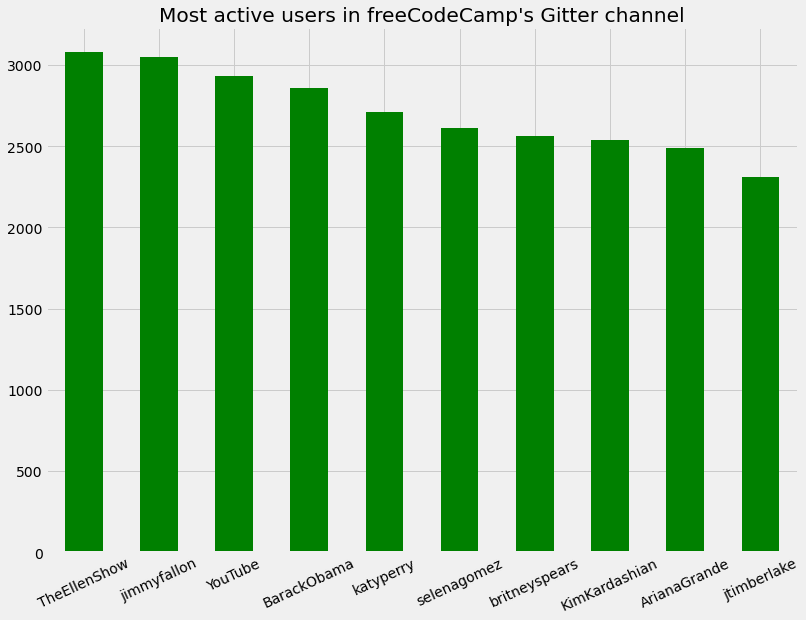

0     is history repeating itself     dontnormalizeh...
1      barackobama thank you for your incredible gra...
2                                          life goals  
3                                me right now          
4     sisters are doin  it for themselves           ...
5     happy 96th gma  fourmoreyears         lacma lo...
8              2017 resolution  to embody authenticity 
9                                             sisters  
10    happy holidays  sending love and light to ever...
11    damn  it s hard to wrap presents when you re d...
12    when my whole fam tryna have a peaceful holida...
13    when your holiday shopping is woke af       bl...
14                 shannonwoodward have you been hacked
15    this week santa and i got to spread some cheer...
16             love the music therapy program at chla  
17                                        for real tho 
18    i can t wait to recreate this on a tour we do ...
19                             i wanna adopt him

In [52]:
plt.style.use('fivethirtyeight')

f, g = plt.subplots(figsize=(12, 9))
df['user'].value_counts().head(10).plot.bar(color="green")
g.set_xticklabels(g.get_xticklabels(), rotation=25)
plt.title("Most active users in freeCodeCamp's Gitter channel")
plt.show(g)

df.tweet.head(20)

In [18]:
user = df.tweet

n_messages = len(user)
n_chars = len(' '.join(map(str, user)))

print("accounts all together have %d messages" % n_messages)
print("Their messages add up to %d characters" % n_chars)

accounts all together have 46934 messages
Their messages add up to 3715899 characters


In [19]:
sample_size = int(len(user) * 0.2)

user = user[:sample_size]
user = ' '.join(map(str, user)).lower()

user[:100] # Show first 100 characters

'is history repeating itself     dontnormalizehate   barackobama thank you for your incredible grace '

In [20]:
chars = sorted(list(set(user)))
print('Count of unique characters (i.e., features):', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Count of unique characters (i.e., features): 37


In [21]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(user) - maxlen, step):
    sentences.append(user[i: i + maxlen])
    next_chars.append(user[i + maxlen])
print('Number of sequences:', len(sentences), "\n")

print(sentences[:10], "\n")
print(next_chars[:10])


Number of sequences: 247831 

['is history repeating itself     dontnorm', 'history repeating itself     dontnormali', 'tory repeating itself     dontnormalizeh', 'y repeating itself     dontnormalizehate', 'epeating itself     dontnormalizehate   ', 'ating itself     dontnormalizehate   bar', 'ng itself     dontnormalizehate   barack', 'itself     dontnormalizehate   barackoba', 'elf     dontnormalizehate   barackobama ', '     dontnormalizehate   barackobama tha'] 

['a', 'z', 'a', ' ', 'b', 'a', 'o', 'm', 't', 'n']


In [22]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

<ipython-input-22-b8405c8d7c41>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
<ipython-input-22-b8405c8d7c41>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [24]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

D:\Anaconda\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [27]:
def on_epoch_end(epoch, logs):
    # Function invoked for specified epochs. Prints generated text.
    # Using epoch+1 to be consistent with the training epochs printed by Keras
    if epoch+1 == 1 or epoch+1 == 15:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(user) - maxlen - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = user[start_index: start_index + maxlen]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(140):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()
    else:
        print()
        print('----- Not generating text after Epoch: %d' % epoch)

generate_text = LambdaCallback(on_epoch_end=on_epoch_end)

In [28]:
# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model using our gpu
with tf.device('/gpu:0'):
    model.fit(x, y,
              batch_size=128,
              epochs=15,
              verbose=2,
              callbacks=[generate_text, checkpoint])

Epoch 1/15

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ama discusses the importance of expandin"
ama discusses the importance of expanding the world tour                                                                                                                            
----- diversity: 0.5
----- Generating with seed: "ama discusses the importance of expandin"
ama discusses the importance of expanding a pass and stay                                                        president obama         the                                        
----- diversity: 1.0
----- Generating with seed: "ama discusses the importance of expandin"
ama discusses the importance of expanding  so cover   obamamastal you today derroint what sope now sittarity down tosine sought    president obama  ant to turcee    the middle cill
----- diversity: 1.2
----- Generating with seed: "ama discusses the importance of expandin"
ama discusses the importance of expandin

In [74]:
text = np.array(['this is just some random, stupid text'])
print(text.shape)

tk = keras.preprocessing.text.Tokenizer(
        nb_words=2000,
        lower=True,
        split=" ")

tk.fit_on_texts(text)
pred = tk.texts_to_sequences(text)
print(pred)

prediction = model.predict(np.array(tk.texts_to_sequences(text)))
print(prediction)

(1,)
[[1, 2, 3, 4, 5, 6, 7]]


D:\Anaconda\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


ValueError: in user code:

    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Anaconda\lib\site-packages\keras\engine\input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None), dtype=int32)
      • training=False
      • mask=None
